# Problema de Otimização do Transporte

## 1 - Natureza do Problema
Trata-se de um problema de maximização do lucro

In [3]:
import random
import numpy
import json
import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

# INIT
toolbox = base.Toolbox()

# Definindo a natureza do problema. No caso um problema de maximização
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

## 2 - Variáveis e Codificação
- A codificação utilizada será um comossomo com 70 genes onde cada gene representa a rota que o caminhão está alocado.
- Como temos 25 rotas possíveis para cada caminhão precisaremos 5 bits para cada gene e logo teremos um cromossomo de tamanho 350 ($5*70$). Optou-se utilizar somente as rotas com valor ao invés de todas as possíveis, para reduzir o espaço de busca, bem como não gerar soluções inválidas
- O espaço de busca  total é de aproximadamente $2,3*10^{105}$

In [4]:
#MONTADORA-DESTINO
rotas = [
        'GMS-RIO','GMS-BSB','GMS-CNF','GMS-CWB','GMS-REC',
        'RNT-SAO','RNT-RIO','RNT-CNF','RNT-POA',
        'FRD-RIO','FRD-CWB','FRD-POA',
        'FAT-SAO','FAT-BSB','FAT-CWB','FAT-REC',
        'VKW-RIO','VKW-BSB','VKW-CWB','VKW-POA',
        'HYD-SAO','HYD-CNF','HYD-CWB','HYD-REC','HYD-POA']

# Demanda mensal dos veículos de cada MONTADORA-CENTRO_CONSUMIDOR
demandas = {
        'GMS-RIO':1701, 'GMS-BSB':1039, 'GMS-CNF':1072, 'GMS-CWB':975, 'GMS-REC':374, 
        'RNT-SAO':1903, 'RNT-RIO':684 , 'RNT-CNF':431 , 'RNT-POA':218, 
        'FRD-RIO':953 , 'FRD-CWB':547 , 'FRD-POA':304 , 
        'FAT-SAO':5246, 'FAT-BSB':1152, 'FAT-CWB':1081, 'FAT-REC':414, 
        'VKW-RIO':1689, 'VKW-BSB':1031, 'VKW-CWB':968 , 'VKW-POA':538, 
        'HYD-SAO':1360, 'HYD-CNF':308 , 'HYD-CWB':281 , 'HYD-REC':108, 'HYD-POA':156}

# Menor distância entre MONTADORA-CENTRO_CONSUMIDOR
distancias = {
        'GMS-RIO':448, 'GMS-BSB':1021, 'GMS-CNF':589 , 'GMS-CWB':445, 'GMS-REC':2709, 
        'RNT-SAO':413, 'RNT-RIO':853 , 'RNT-CNF':1001, 'RNT-POA':728, 
        'FRD-RIO':465, 'FRD-CWB':434 , 'FRD-POA':1162, 
        'FAT-SAO':554, 'FAT-BSB':746 , 'FAT-CWB':962 , 'FAT-REC':2153, 
        'VKW-RIO':465, 'VKW-BSB':1027, 'VKW-CWB':434 , 'VKW-POA':1162, 
        'HYD-SAO':157, 'HYD-CNF':650 , 'HYD-CWB':539 , 'HYD-REC':2745, 'HYD-POA':1267}

# Custo total do transporte por viagem completa realizada
custos = {
        'GMS-RIO':7948 , 'GMS-BSB':21167, 'GMS-CNF':9557 , 'GMS-CWB':6729 , 'GMS-REC':58599, 
        'RNT-SAO':5629 , 'RNT-RIO':15612, 'RNT-CNF':16679, 'RNT-POA':12365, 
        'FRD-RIO':8314 , 'FRD-CWB':6608 , 'FRD-POA':19157, 
        'FAT-SAO':7503 , 'FAT-BSB':15987, 'FAT-CWB':14991, 'FAT-REC':48046, 
        'VKW-RIO':12578, 'VKW-BSB':32363, 'VKW-CWB':9997 , 'VKW-POA':28981, 
        'HYD-SAO':1050 , 'HYD-CNF':5527 , 'HYD-CWB':4290 , 'HYD-REC':31247, 'HYD-POA':10927}

# Remuneração do transporte por viagem completa realizada
remuneracoes = {
        'GMS-RIO':10703, 'GMS-BSB':24398, 'GMS-CNF':14069, 'GMS-CWB':10626, 'GMS-REC':64746, 
        'RNT-SAO':10615, 'RNT-RIO':21923, 'RNT-CNF':25729, 'RNT-POA':18711, 
        'FRD-RIO':12606, 'FRD-CWB':11759, 'FRD-POA':31504, 
        'FAT-SAO':11407, 'FAT-BSB':15356, 'FAT-CWB':19800, 'FAT-REC':44330, 
        'VKW-RIO':11528, 'VKW-BSB':25465, 'VKW-CWB':10758, 'VKW-POA':28820, 
        'HYD-SAO':4961 , 'HYD-CNF':20537, 'HYD-CWB':17028, 'HYD-REC':86746, 'HYD-POA':40040}

In [5]:
# Definindo a estrutura do indivíduo
IND_SIZE = 350  # Tamanho do individuo - 10 para cada gene
GEN_SIZE = 5
GENES = IND_SIZE/GEN_SIZE

creator.create("Individual", list, fitness=creator.FitnessMax)

# funcao para gerar o gene com valores 0 ou 1 randomicamente uniforme
toolbox.register("attr_bool", random.randint, 0, 1)

# funcao para gerar o indivíduo (nome, forma de gerar, Estrutura, funcao geradora, tamanho)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=IND_SIZE)

# funcao para gerar a populacao
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def decode(individual,i_size=IND_SIZE,g_size=GEN_SIZE):
    """Recebe um individuo codificado e decodifica."""
    result = []
    for a in range(0,i_size,g_size):
        gene = ''.join(str(individual[i]) for i in range(a,a+g_size))
        index_rota = int(gene,2)
        rota = '' if index_rota > len(rotas) - 1 else rotas[index_rota]
        result.append(rota)
    return result

## 3 - Restrições
As restrições servem para definir um limite de soluções possíveis para algoritmo e, dependendo da abordagem, penalizar a função de fitness ou apenas descartas as soluções com respostas fora do intervalo.  

- **Demanda Mensal maior ou igual ao valor tabelado.**  
Criação de uma função para realização do cálculo com base no indivíduo e no valor tabelado
- **Maximo transportado por rota**
Com base no tempo que um caminhao demora, tem-se o valor máximo dia/mes que esse caminhão faz


Criou-se tabelas adicionais para facilitar o cálculo:  
- quantidade que um caminhao carrega por mes, por rota  
- quantidade de caminhoes minima por rota para atender a demanda  

In [47]:
def c_mes(distancia):
    """Carga total que um caminhao carrega no mes dada uma distancia a percorrer"""
    tempo_ida = distancia/65 + 2 #60km/h + 2hs de carga
    tempo_volta = distancia/80 + 2 #80km/h + 2hs descarga
    tempo_total = round(tempo_ida + tempo_volta)
    horas_mes = 24 * 30 #24hs * 30 dias
    viagens_mes = int(horas_mes/tempo_total)
    
    return 11 * viagens_mes #11 carros por caminhao

# Carga total mensal que um caminhao consegue carregar na rota
carga_mes = dict((rota,c_mes(distancias[rota])) for rota in rotas)

# Quantidade total de caminhoes mes para atender a demanda da rota
caminhoes_mes = dict((rota,int(demandas[rota]/carga_mes[rota])+1) for rota in rotas)

In [83]:
print('CARGA TOTAL MENSAL CAMINHAO POR ROTA:\n{}'.format(json.dumps(carga_mes, indent=1)))
print('\nQUANTIDADE NECESSARIA CAMINHAO POR ROTA:\n{}'.format(json.dumps(caminhoes_mes, indent=1)))

CARGA TOTAL MENSAL CAMINHAO POR ROTA:
{
 "GMS-RIO": 495,
 "GMS-BSB": 242,
 "GMS-CNF": 396,
 "GMS-CWB": 495,
 "GMS-REC": 99,
 "RNT-SAO": 495,
 "RNT-RIO": 275,
 "RNT-CNF": 242,
 "RNT-POA": 330,
 "FRD-RIO": 462,
 "FRD-CWB": 495,
 "FRD-POA": 220,
 "FAT-SAO": 407,
 "FAT-BSB": 308,
 "FAT-CWB": 253,
 "FAT-REC": 121,
 "VKW-RIO": 462,
 "VKW-BSB": 231,
 "VKW-CWB": 495,
 "VKW-POA": 220,
 "HYD-SAO": 990,
 "HYD-CNF": 352,
 "HYD-CWB": 407,
 "HYD-REC": 88,
 "HYD-POA": 198
}

QUANTIDADE NECESSARIA CAMINHAO POR ROTA:
{
 "GMS-RIO": 4,
 "GMS-BSB": 5,
 "GMS-CNF": 3,
 "GMS-CWB": 2,
 "GMS-REC": 4,
 "RNT-SAO": 4,
 "RNT-RIO": 3,
 "RNT-CNF": 2,
 "RNT-POA": 1,
 "FRD-RIO": 3,
 "FRD-CWB": 2,
 "FRD-POA": 2,
 "FAT-SAO": 13,
 "FAT-BSB": 4,
 "FAT-CWB": 5,
 "FAT-REC": 4,
 "VKW-RIO": 4,
 "VKW-BSB": 5,
 "VKW-CWB": 2,
 "VKW-POA": 3,
 "HYD-SAO": 2,
 "HYD-CNF": 1,
 "HYD-CWB": 1,
 "HYD-REC": 2,
 "HYD-POA": 1
}


Com essas tabelas já é possível verificar que a frota de 70 caminhões não consegue atender toda a demanda.

In [7]:
print('Tamanho mínimo da frota para atender a demanda: {}'.format(sum(caminhoes_mes.values())))

Tamanho mínimo da frota para atender a demanda: 82


In [8]:
# diferenca com a quantidade ideal de caminhoes para atender a demanda
def restriction(individual):
    resultado = dict((rota,len([r for r in decode(individual) if rota in r] )) for rota in rotas)
    erro = 0
    for r in rotas:
        erro += abs(resultado[r]-caminhoes_mes[r])
    erro_medio = erro/sum(caminhoes_mes.values())
    return erro_medio

# funcao objetivo normalizada
def goal(individual):
    arranjo = decode(individual)
    remuneracao = sum((remuneracoes[k]*carga_mes[k]/11) for k in arranjo if k)
    despesa = sum((custos[k]*carga_mes[k]/11) for k in arranjo if k)
    # 66794420 refere-se ao lucro maximo todos os caminhoes na rota mais lucrativa
    return (remuneracao-despesa)/66794420 

# funcao fitness
def evaluate(individual):
    #0.5 (somado ao final) foi um fator de normalização empírico
    return goal(individual) - 0.5*restriction(individual) + 0.5, 

In [105]:
def plot_log(logbook):
    """Funcao auxiliar para plotar gráfico"""
    gen = logbook.select("gen")
    min = logbook.select("min")
    avg = logbook.select("avg")
    max = logbook.select("max")
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Geração")
    ax1.set_ylabel("Fitness", color="b")
    
    line1 = ax1.plot(gen, min, "b-", label="Mínimo")
    line2 = ax1.plot(gen, avg, "g-", label="Médio")
    line3 = ax1.plot(gen, max, "y-", label="Máximo")

    lns = line3 + line2 + line1
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=4)
    
    fig.set_size_inches(15, 5, forward=True)

    plt.show()
    
def print_info(selected):
    """Funcao auxiliar para imprimir informções da solução encontrada"""
    melhor = decode(selected)
    print('\nMELHOR INDIVIDUO:\n {}'.format(melhor))

    #conta os caminhoes por rota para comparar com o ideal
    resultado_caminhoes = dict((rota,len([r for r in melhor if rota in r] )) for rota in rotas) 
    resultado_demanda = dict((k,v*carga_mes[k]) for k,v in resultado_caminhoes.items())
    
    print('\nSOLUÇÃO ESPERADA PARA ATENDER A DEMANDA[DEMANDA]:\n {}'.format(json.dumps(demandas, indent=1)))
    print('\nSOLUÇÃO ESPERADA PARA ATENDER A DEMANDA[CAMINHOES]:\n {}'.format(json.dumps(caminhoes_mes, indent=1)))

    print('\nSOLUÇÃO ENCONTRADA[DEMANDA]:\n {}'.format(json.dumps(resultado_demanda, indent=1)))
    print('\nSOLUÇÃO ENCONTRADA[CAMINHOES]:\n {}'.format(json.dumps(resultado_caminhoes, indent=1)))

    erro = sum((demandas[r]-resultado_demanda[r]) for r in rotas if demandas[r]-resultado_demanda[r] > 0)
    divergencia = erro*100/sum(demandas.values())

    rendimento = sum((remuneracoes[k]*carga_mes[k]/11) for k in melhor if k)
    despesa = sum((custos[k]*carga_mes[k]/11) for k in melhor if k)
    lucro = rendimento-despesa

    print('\nSATISFABILIDADE = {}%'.format(round(100-divergencia,2)))
    print('\nLUCRO = {}'.format(round(lucro,2)))

## 8 - Código AG
Implementação de Algoritmo Genético para resolução do problema

Definindo parâmentros e funções utilizadas pelo algoritmo

In [10]:
# registra funcao de fitness
toolbox.register("evaluate", evaluate)

# registra crossOver
toolbox.register("mate", tools.cxTwoPoint)

# registra mutacao com probabilidade default de mudar cada gene de 5%
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

# registra o metodo de selecao como torneio de tamanho 3
toolbox.register("select", tools.selTournament, tournsize=2)

#semente para gerar população
random.seed(32)

# cria populacao inicial
pop = toolbox.population(n=100)

# CXPB - probabilidade de crossover
# MUTPB - probabilidade de mutacao
# NGEN - numero de geracoes
CXPB, MUTPB, NGEN = 0.8, 0.03, 100

#definindo quais stats devem ser mostrados no console
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("avg", numpy.mean)
stats.register("max", numpy.max)

Rodando o algoritmo com os parâmetros definidos:

In [11]:
#Algoritmos do livro “Evolutionary Computation 1 : Basic Algorithms and Operators”
#roda o algoritmo do capitulo 7
pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats=stats, verbose=True)

gen	nevals	std      	min     	avg     	max     
0  	100   	0.0315185	0.265136	0.337622	0.411556
1  	74    	0.0265088	0.287718	0.350289	0.417469
2  	76    	0.0302276	0.273199	0.363509	0.456218
3  	76    	0.0230867	0.321714	0.380451	0.451394
4  	86    	0.0228009	0.323559	0.382703	0.451394
5  	81    	0.022721 	0.321345	0.390113	0.448661
6  	85    	0.0221087	0.336761	0.397599	0.446785
7  	84    	0.0221145	0.316898	0.403218	0.438982
8  	89    	0.0231797	0.337453	0.405261	0.458005
9  	70    	0.0221976	0.351498	0.40907 	0.458219
10 	69    	0.0207922	0.328085	0.413141	0.452896
11 	82    	0.01986  	0.356413	0.418112	0.459242
12 	77    	0.0210007	0.337398	0.418364	0.459346
13 	80    	0.0209157	0.344935	0.420312	0.470402
14 	83    	0.019298 	0.38004 	0.425603	0.462683
15 	77    	0.0202628	0.368406	0.421408	0.461973
16 	78    	0.0188409	0.373809	0.425091	0.46559 
17 	88    	0.0170442	0.393709	0.430448	0.482371
18 	88    	0.0212627	0.38432 	0.430758	0.480952
19 	85    	0.0232536	0.370311	0.434903	0

Imprimindo as informções referente ao melhor indivíduo

In [107]:
#Seleciona o melhor individuo da populacao resultante
best_ind = tools.selSPEA2(pop, 1)

#Imprime as informações do melhor individuo
print_info(best_ind[0])



MELHOR INDIVIDUO:
 ['FRD-CWB', 'FAT-BSB', 'GMS-CWB', 'GMS-CNF', 'VKW-CWB', 'FAT-SAO', 'FAT-CWB', 'RNT-SAO', 'GMS-RIO', 'HYD-POA', 'FAT-REC', 'FAT-SAO', 'GMS-CNF', 'FRD-CWB', 'FAT-SAO', 'RNT-RIO', 'RNT-SAO', 'RNT-CNF', 'HYD-REC', 'VKW-RIO', 'HYD-CNF', 'FAT-CWB', 'VKW-BSB', 'FAT-REC', 'GMS-REC', 'VKW-RIO', 'HYD-SAO', 'GMS-RIO', 'RNT-SAO', 'GMS-CWB', 'GMS-RIO', 'FAT-SAO', 'HYD-SAO', 'VKW-BSB', 'FAT-SAO', 'FAT-SAO', 'FRD-RIO', 'FRD-POA', 'VKW-CWB', 'GMS-CNF', 'RNT-RIO', 'FAT-SAO', 'HYD-CWB', 'HYD-REC', 'FAT-SAO', 'FRD-RIO', 'GMS-REC', 'GMS-RIO', 'GMS-BSB', 'RNT-RIO', 'FAT-CWB', 'GMS-BSB', 'FAT-SAO', 'FAT-BSB', 'VKW-BSB', 'RNT-SAO', 'FAT-REC', 'FAT-SAO', 'RNT-POA', 'FAT-SAO', 'FRD-POA', 'FAT-SAO', 'FRD-RIO', 'VKW-BSB', 'FAT-SAO', 'VKW-POA', 'GMS-REC', 'FAT-CWB', 'RNT-CNF', 'GMS-BSB']

SOLUÇÃO ESPERADA PARA ATENDER A DEMANDA[DEMANDA]:
 {
 "GMS-RIO": 1701,
 "GMS-BSB": 1039,
 "GMS-CNF": 1072,
 "GMS-CWB": 975,
 "GMS-REC": 374,
 "RNT-SAO": 1903,
 "RNT-RIO": 684,
 "RNT-CNF": 431,
 "RNT-POA": 218

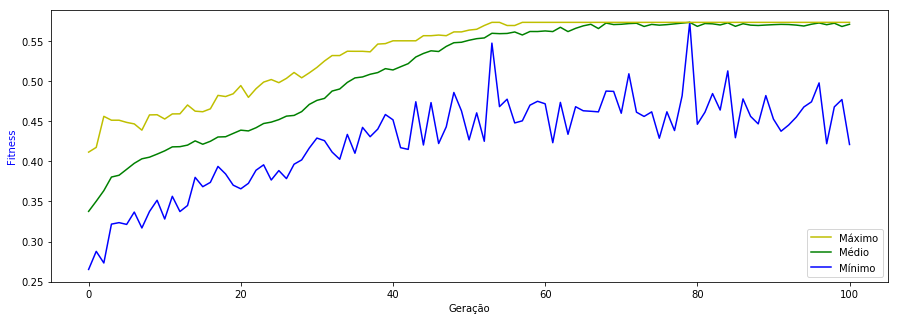

In [108]:
#Plota gráfico
plot_log(logbook)